In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hpg-clean/test data.csv
/kaggle/input/hpg-clean/train data.csv


In [2]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import math
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00:00:010:01


In [3]:
train_data = pd.read_csv('/kaggle/input/hpg-clean/train data.csv')
test_data = pd.read_csv('/kaggle/input/hpg-clean/test data.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Trading Date       1035 non-null   object 
 1   Closing Price      1035 non-null   float64
 2   Opening Price      1035 non-null   float64
 3   Highest Price      1035 non-null   float64
 4   Lowest Price       1035 non-null   float64
 5   Trading Volume     1035 non-null   float64
 6   Percentage Change  1035 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.7+ KB


In [5]:
train_df = train_data.sort_values(by=['Trading Date'])
test_df = test_data.sort_values(by=['Trading Date'])
train_df['Trading Date'] = pd.to_datetime(train_df['Trading Date'])
test_df['Trading Date'] = pd.to_datetime(test_df['Trading Date'])
train_df = train_df.set_index('Trading Date')
test_df = test_df.set_index('Trading Date')

In [6]:
train_df

,Closing Price,Opening Price,Highest Price,Lowest Price,Trading Volume,Percentage Change
Trading Date,,,,,,
2018-01-02,11991.0,11789.9,12003.6,11676.8,15.73,1.81
2018-01-03,11965.9,12066.4,12192.1,11890.5,18.51,-0.21
2018-01-04,12116.7,12016.2,12167.0,11965.9,17.79,1.26
2018-01-05,12066.4,12091.6,12179.6,11978.4,14.03,-0.42
2018-01-08,12443.5,11991.0,12443.5,11940.7,14.19,3.13
...,...,...,...,...,...,...
2022-02-22,35116.6,35041.0,35268.0,34586.9,22.97,-0.54
2022-02-23,35343.7,35305.8,35722.1,35003.1,16.88,0.65
2022-02-24,34813.9,35381.5,35457.2,34132.8,29.18,-1.50


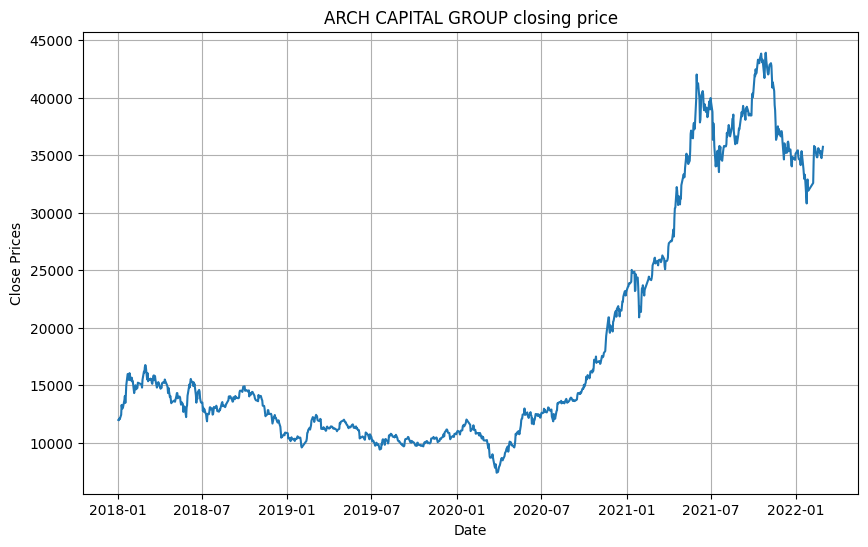

In [7]:
#plot close price in train data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train_df['Closing Price'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

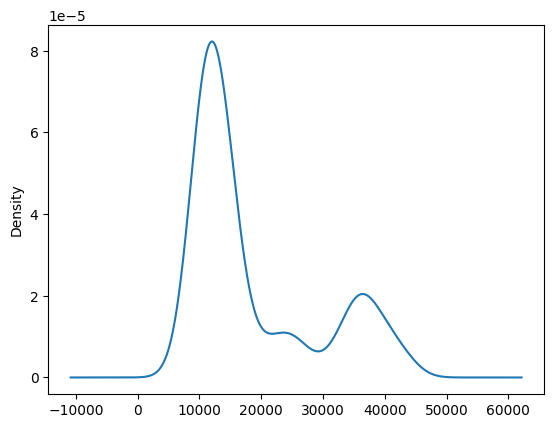

In [8]:
train_close = train_df['Closing Price']
test_close = test_df['Closing Price']
train_close.plot(kind='kde')

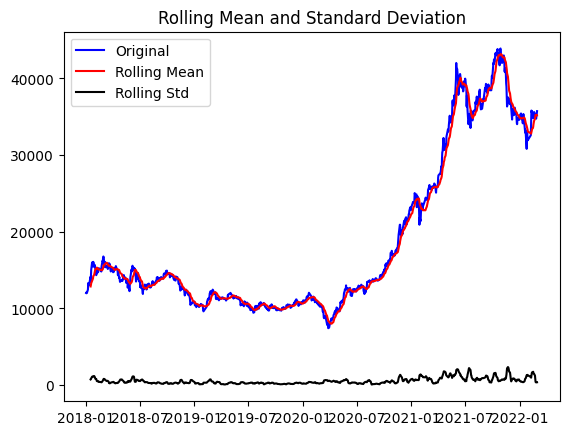

Results of dickey fuller test
Test Statistics                  -0.253140
p-value                           0.931884
No. of lags used                 22.000000
Number of observations used    1012.000000
critical value (1%)              -3.436828
critical value (5%)              -2.864400
critical value (10%)             -2.568293
dtype: float64


In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(train_close)

<Figure size 640x480 with 0 Axes>

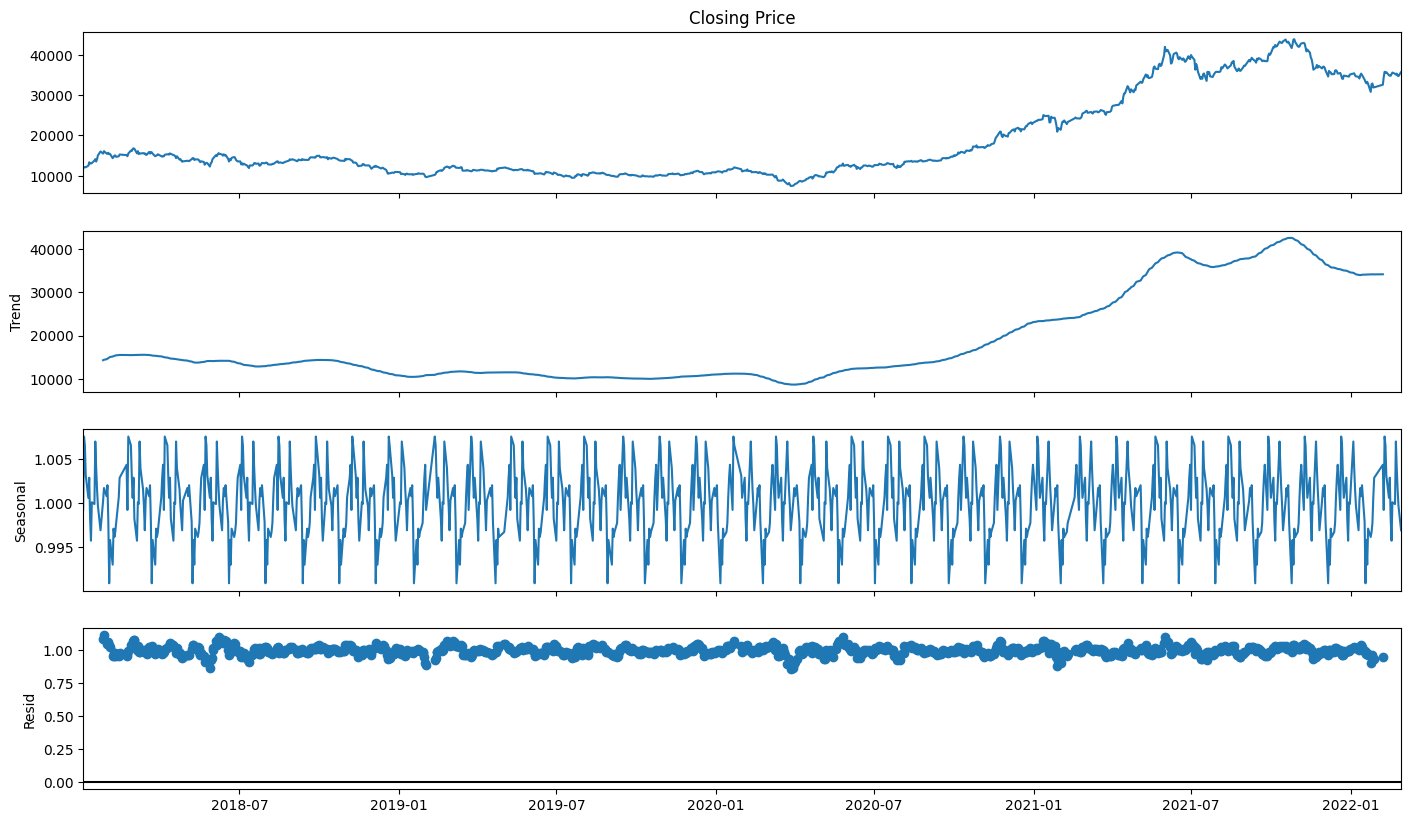

In [10]:
result = seasonal_decompose(train_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

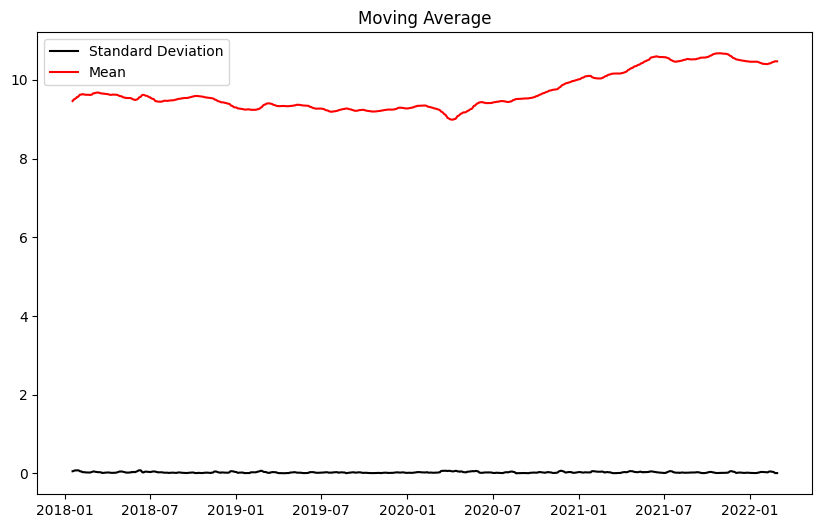

In [11]:
#using log to eliminate the trend and seasonality
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(train_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [12]:
df_log_train = np.log(train_df['Closing Price'])
df_log_test = np.log(test_df['Closing Price'])

In [13]:
df_log_train

Trading Date
2018-01-02     9.391912
2018-01-03     9.389816
2018-01-04     9.402340
2018-01-05     9.398180
2018-01-08     9.428954
                ...    
2022-02-22    10.466429
2022-02-23    10.472875
2022-02-24    10.457772
2022-02-25    10.455595
2022-02-28    10.483525
Name: Closing Price, Length: 1035, dtype: float64

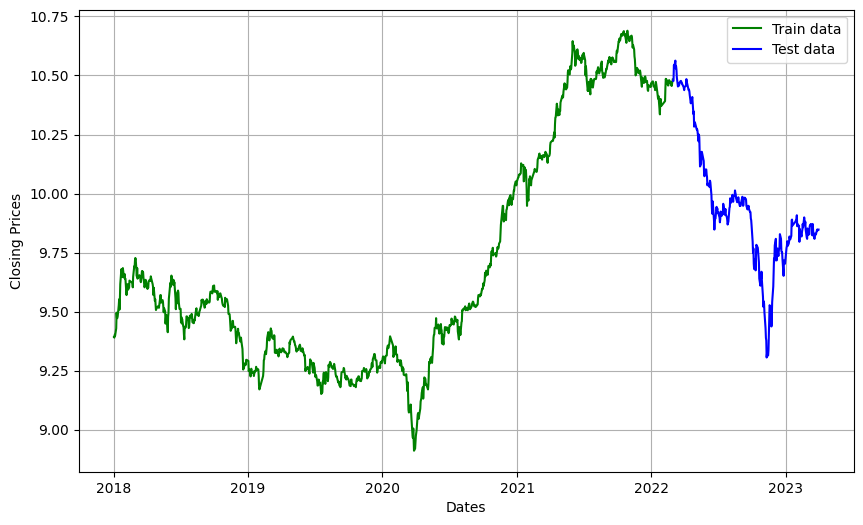

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_train, 'green', label='Train data')
plt.plot(df_log_test, 'blue', label='Test data')
plt.legend()

In [15]:
differenced_train = train_close.diff().dropna()

# Re-check stationarity
result = adfuller(differenced_train)
print('ADF Statistic after differencing (train):', result[0])
print('p-value after differencing (train):', result[1])

ADF Statistic after differencing (train): -5.162120533492637
p-value after differencing (train): 1.0500420128293492e-05


In [16]:
differenced_train_log = df_log_train.diff().dropna()

# Re-check stationarity
result = adfuller(differenced_train_log)
print('ADF Statistic after differencing (train):', result[0])
print('p-value after differencing (train):', result[1])

ADF Statistic after differencing (train): -32.15375565337124
p-value after differencing (train): 0.0


<Axes: xlabel='Trading Date'>

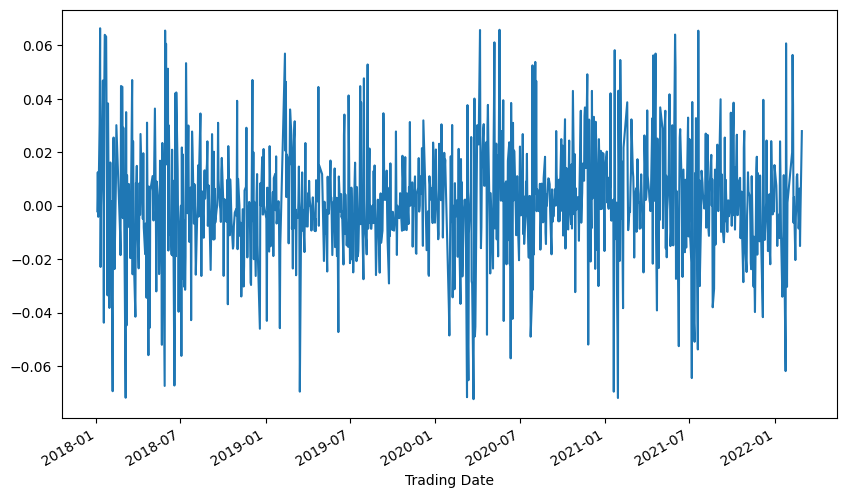

In [17]:
differenced_train_log.plot()

after using log and first order differencing, we have this plot. we can see that the data looks more stationary

**** Model

TH1: Use prediction data to update train

In [18]:
import warnings
warnings.filterwarnings('ignore')
train_ar = df_log_train
test_ar = df_log_test

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(method_kwargs={"disp": 0})
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    #history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 0.364
Symmetric mean absolute percentage error: 5.332


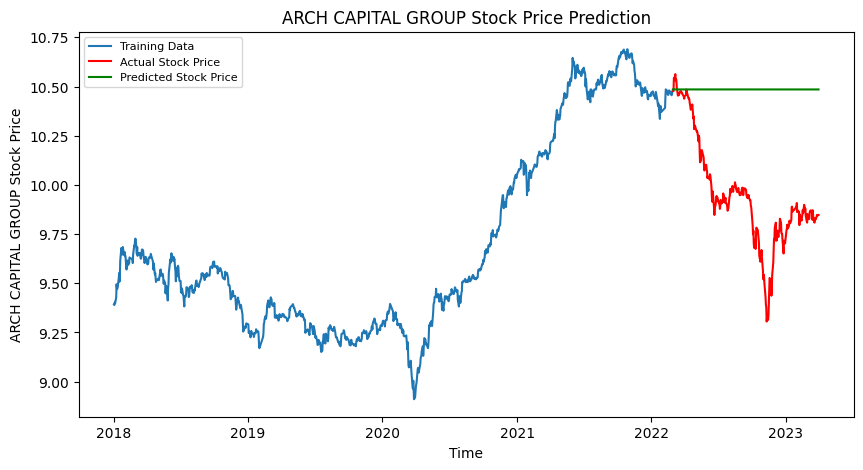

R-squared: -3.9076556148531374
Mean Absolute Percentage Error (MAPE): 5.516430803809453 %
Root Mean Squared Error: 0.6035805019906896


In [19]:
fc = pd.Series(predictions, index = df_log_test.index)
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_log_train, label='Training Data')
plt.plot(df_log_test, color='red', label='Actual Stock Price')
plt.plot(fc, color='green', label='Predicted Stock Price')
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Calculate R-squared (adjusted for ARIMA models)
r2 = r2_score(df_log_test, fc)
print(f'R-squared: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df_log_test, fc) * 100  # Multiply by 100 for percentage
print('Mean Absolute Percentage Error (MAPE):', mape, '%')

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(df_log_test, fc))
print('Root Mean Squared Error:', rmse)

TH2: using real test data to update train


In [20]:
import warnings
warnings.filterwarnings('ignore')
train_ar = df_log_train
test_ar = df_log_test

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(method_kwargs={"disp": 0})
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 0.001
Symmetric mean absolute percentage error: 0.225


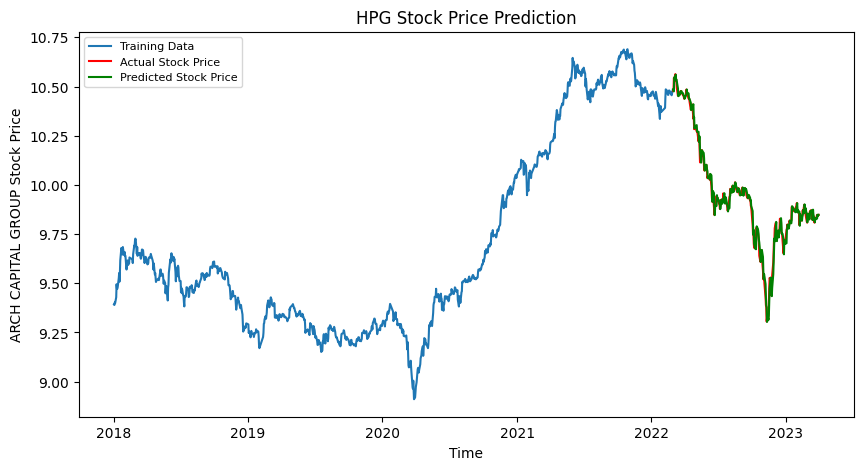

R-squared: 0.9879535824126818
Mean Absolute Percentage Error (MAPE): 0.22547026678396376 %
Root Mean Squared Error: 0.029903850935192204


In [21]:
fc = pd.Series(predictions, index = df_log_test.index)
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_log_train, label='Training Data')
plt.plot(df_log_test, color='red', label='Actual Stock Price')
plt.plot(fc, color='green', label='Predicted Stock Price')
plt.title('HPG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Calculate R-squared (adjusted for ARIMA models)
r2 = r2_score(df_log_test, fc)
print(f'R-squared: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df_log_test, fc) * 100  # Multiply by 100 for percentage
print('Mean Absolute Percentage Error (MAPE):', mape, '%')

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(df_log_test, fc))
print('Root Mean Squared Error:', rmse)

In [22]:
fc_invert = list()
for value in predictions:
    fc_invert.append(np.e**value)

In [23]:
test_df

,Closing Price,Opening Price,Highest Price,Lowest Price,Trading Volume,Percentage Change
Trading Date,,,,,,
2022-03-01,35495.0,36100.5,36403.2,35457.2,30.39,-0.64
2022-03-02,35495.0,35570.7,35835.6,35268.0,25.86,0.00
2022-03-03,37916.9,36024.8,37916.9,35797.8,99.11,6.82
2022-03-04,37689.8,38598.0,38825.1,37689.8,43.39,-0.60
2022-03-07,38673.7,37992.6,39733.3,37841.2,49.99,2.61
...,...,...,...,...,...,...
2023-03-27,18909.0,18545.0,19000.0,18500.0,22.29,1.96
2023-03-28,18818.0,19000.0,19091.0,18818.0,13.56,-0.48
2023-03-29,18909.0,18818.0,19182.0,18818.0,19.74,0.48


In [24]:
# Calculate R-squared (adjusted for ARIMA models)
r2 = r2_score(test_df['Closing Price'], fc_invert)
print(f'R-squared: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test_df['Closing Price'], fc_invert) * 100  # Multiply by 100 for percentage
print('Mean Absolute Percentage Error (MAPE):', mape, '%')

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(test_df['Closing Price'], fc_invert))
print('Root Mean Squared Error:', rmse)

R-squared: 0.9908821262258023
Mean Absolute Percentage Error (MAPE): 2.2292542770015444 %
Root Mean Squared Error: 608.1413181750931


In [ ]:
model_fit.summary()